# Neural Network Model for Cervical Cancer Classification
This notebook executes the neural network classifier for cervical cancer prediction. By using risk_factors_cervical_cancer.csv as input dataset, we can compute the prtediction whether each patient get a positive or negative at biopsy test. For more information on the biopsy test, please refer to the following website for a description, if necessary.
https://www.cancer.net/navigating-cancer-care/diagnosing-cancer/tests-and-procedures/biopsy

### How to use this notebook?
To run this Notebook, you will need the corresponding data file "risk_factors_cervical_cancer.csv" and the python file "critical_cancer.py" for data processing. Please place these two files in the same directory as Jupyter notebook before running.

In [ ]:
#install pytorch if you do not have installed
!pip install torch torchsummaryX --quiet

# import time to visualize the total training time 
from time import time

# install libraries for computation of model: NumPy, Pandas, PyTorch, TorchsummaryX, Scikitlearn 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummaryX import summary
from sklearn.metrics import accuracy_score, precision_score, recall_score

# install libraries for utilities: gc, tqdm, os, datetime 
import gc
from tqdm.auto import tqdm
import os
import sys
import datetime
import matplotlib.pyplot as plt

#install confusion matrix for comparison to grand truth
from sklearn import metrics

# install ETL
from cervical_cancer import CervicalCancer

# setup GPU if we use it; else work on CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

/content/drive/MyDrive/Colab Notebooks/ECT
/content
Device:  cpu


In [ ]:
# install and import skater and skater.core.explanations.Interpretation 
!pip install git+https://github.com/oracle/Skater.git
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/oracle/Skater.git to /tmp/pip-req-build-sqvl5ah0
  Running command git clone -q https://github.com/oracle/Skater.git /tmp/pip-req-build-sqvl5ah0
     |████████████████████████████████| 275 kB 4.0 MB/s 
     |████████████████████████████████| 132 kB 57.1 MB/s 
  Created wheel for skater: filename=skater-1.1.2b1-py3-none-any.whl size=4637020 sha256=033e10ff4aa2cf6021c07be5ecb4c7492e2bebb52084063da91dc97bb383e1ea
  Stored in directory: /tmp/pip-ephem-wheel-cache-j1w7rt6q/wheels/88/fb/54/c5a75c31373e0c38ba379e3ebd04dde7024e706333480e03a2
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=3e2f1f8a9133653464a0c500defa4d25e059ffd0e3a8e6554624cd8c5b4c6276
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built skater lime


In [ ]:
class BinaryBalancedSampler(DataLoader):
    '''
    This class uses as dataloader inheriting PyTorch DataLoader.
    Because the dataset mitigates the imbalance between biopsy test results in positive and negative, 
    stratify the sample by positive and negative results and oversampling the positive data to a specified number of samples.
    Arguments:
        dataset: Specify the data set to be used. Do not separate the input and target variables at this time. 
                 Target variables should be processed so that they are in the last column.
        n_samples: Specifies how many samples of positive results are to be obtained per batch.
        balance: Specifies whether to balance positives and negatives; if True, balancing is performed according to the value specified in n_samples.
        verbose: Specifies whether or not to print the processed results; if True, the processed results will be printed.
        shuffle: Specifies whether or not to shuffle the order of samples picked up by the data loader; for test, specify this value as false.
    '''
    def __init__(self, dataset, n_samples=50, balance = False, verbose=False, shuffle=False):
        '''
        Constructor function of class. During this process, data stratification, shuffling, and batch replacement of data types for tensor conversion are performed.
        '''
        super(DataLoader, self).__init__()
        self.dataset = dataset
        self.balance = balance

        # separate dataset as inputs and targets
        self.inputs = self.dataset[:, :-1]
        self.targets = self.dataset[:, -1].astype(np.int64)
        assert self.inputs.shape[0] == self.targets.shape[0]

        #inbalanced data identification
        target_counts = np.bincount(self.targets)
        major_target = target_counts.argmax()
        minor_target = target_counts.argmin()
        self.major_indices = np.where(self.targets == major_target)[0]
        self.minor_indices = np.where(self.targets == minor_target)[0]

        # shuffle
        if shuffle:
            np.random.shuffle(self.major_indices)
            np.random.shuffle(self.minor_indices)

        # convert data as float
        for i in range(self.inputs.shape[1]):
            self.inputs[:, i] = self.inputs[:, i].astype(np.float32)

        # Set length of the dataset: 
        self.length = self.inputs.shape[0]

        # setup some variables for iterative data load
        self.used_indices = 0
        self.count = 0
        self.n_samples = n_samples

        # setup length variable for later use
        self.length = self.dataset.shape[0]

        # Debug: If verbose is True, those messages are printed.
        if verbose:
            print(f"self.inputs {self.inputs.shape}")
            print(f"self.targets {self.targets.shape}")
            print(f"self.length {self.length}")

    def __len__(self):
        '''
        return length of the dataset
        '''
        return self.length

    def __iter__(self):
        '''
        This function iteratively picks up samples from each negative and positive data group separated at constructor.
        Return:
            pair of input data and target data as tensor in PyTorch 
            : the result has the shape of input [n_samples*2, columns of dataset] and targets [n_samples*2, 1]
        '''
        # initialize variables needed at iterative computation
        self.count = 0
        self.used_indices = int(0)

        # if balance process is needed, start while the data can be retreived from dataset
        if self.balance:
            while self.used_indices < len(self.major_indices):
                # pickup n_sample data from negative group 
                indices = self.major_indices[self.used_indices:self.used_indices + self.n_samples].tolist()
                # pickup n_sample data from positive group; allow to nultiple-time sampling
                indices += np.random.choice(self.minor_indices, self.n_samples, replace=True).tolist()

                # convert the data into tensor
                inputs_tensor = torch.tensor(self.inputs[indices].astype(np.float32))
                targets_tensor = torch.tensor(self.targets[indices].astype(np.int64))

                yield inputs_tensor, targets_tensor
                
                self.used_indices += self.n_samples
                self.count += self.n_samples * 2
        # if balance process is not needed, retreive all the data one time 
        else:
            while self.used_indices < self.targets.shape[0]:
                inputs_tensor = torch.tensor(self.inputs[self.used_indices: self.used_indices + self.n_samples].astype(np.float32))
                targets_tensor = torch.tensor(self.targets[self.used_indices: self.used_indices + self.n_samples].astype(np.int64))
                
                yield inputs_tensor, targets_tensor
                
                self.used_indices += self.n_samples
                self.count += self.n_samples * 2

In [ ]:
configs = {
    'train_dataset_ratio':0.8,
    'epochs': 30,
    'batch_size' : 32,
    'learning_rate' : 0.01,
    'weight_decay' : 0,
    'dropout_value' : 0.55,
    'T_max':30,
    'eta_min':0,
    'n_samples':10,
}

In [ ]:
'''
Dataset loading: the dataset has following columns.
Enplanatory varibales
0:Age, 1:Number of sexual partners, 2:First sexual intercourse, 3:Num of pregnancies, 4:Smokes, 
5:Smokes (years), 6:Smokes (packs/year), 7:Hormonal Contraceptives, 8:Hormonal Contraceptives (years), 9:IUD, 
10:IUD (years), 11:STDs, 12:STDs (number), 13:STDs:condylomatosis, 14:STDs:cervical condylomatosis, 
15:STDs:vaginal condylomatosis, 16:STDs:vulvo-perineal condylomatosis, 17:STDs:syphilis, 18:STDs:pelvic inflammatory disease, 19:STDs:genital herpes, 
20:STDs:molluscum contagiosum, 21:STDs:AIDS, 22:STDs:HIV, 23:STDs:Hepatitis B, 24:STDs:HPV, 
25:STDs: Number of diagnosis, 26:STDs: Time since first diagnosis, 27:STDs: Time since last diagnosis, 28:Dx:Cancer, 29:Dx:CIN
30:Dx:HPV, 31:Dx

Target varibales
32:Hinselmann, 33:Schiller, 34:Citology, 35:Biopsy

'''
# load dataset
cervical_cancer = CervicalCancer(data_path='data', file='risk_factors_cervical_cancer.csv', mode='dataframe')

# shuffle data
indices = np.random.permutation(np.arange(cervical_cancer.dataset.shape[0]))
shuffled_dataset = []

# insert shuffled dataset specified columns into shuffled_dataset
column_list = [0, 1, 2, 3, 5, 6, 8, 10, 12, 28, 29, 30, 31, 35]
for i in indices:
    shuffled_dataset.append(cervical_cancer.dataset.iloc[i, column_list])

sd_column_headers = list(cervical_cancer.dataset.columns.values[column_list])
shuffled_dataset = np.array(shuffled_dataset)

# separate shuffled_dataset into train and test dataset
train_dataset_ratio = configs['train_dataset_ratio']
train_dataset_length = int(shuffled_dataset.shape[0] * train_dataset_ratio)
train_dataset = shuffled_dataset[:train_dataset_length].astype(np.float32)
test_dataset = shuffled_dataset[train_dataset_length:].astype(np.float32)

In [ ]:
# Dataloaders will yield a batch of frames and phonemes of given batch_size at every iteration
train_loader = BinaryBalancedSampler(train_dataset, n_samples=configs['n_samples'], balance=True, verbose=True, shuffle=True)
test_loader = BinaryBalancedSampler(test_dataset, balance=False, verbose=True)

self.inputs (686, 13)
self.targets (686,)
self.length 686
self.inputs (172, 13)
self.targets (172,)
self.length 172


In [ ]:
class NeuralNetwork(nn.Module):
    '''
    This class is neural network model. The model has three-layer neural network model, two hidden layers, and an output layer.
    Each layer contains Batch Normalization, ReLU function, and Dropout function to optimize the clasification result.
    The number of neurons in each layer is [256, 128, 64, 2] and this is the typical pyramid network architecture.
    Also, initialization of neuron weights and baises is performed to stabilize the processing results.
    '''
    def __init__(self):
        '''
        Normal constructor. In this constructor, initialize of the neural model and initialization of parameters are executed.
        '''
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            # first layer: lowest layer feature values and activation
            nn.Linear(13, 256, device=device),
            nn.BatchNorm1d(256, device=device),
            nn.ReLU(inplace=True),
            nn.Dropout(configs['dropout_value']),

            # hidden layer 1: hidden feature values
            nn.Linear(256, 128, device=device),
            nn.BatchNorm1d(128, device=device),
            nn.ReLU(inplace=True),
            nn.Dropout(configs['dropout_value']),

            # hidden layer 2: hidden feature values
            nn.Linear(128, 64, device=device),
            nn.BatchNorm1d(64, device=device),
            nn.ReLU(inplace=True),

            # output layer: classification result
            nn.Linear(64, 2, device=device),
        )
        
        # initialization the model weights and model bias
        self.apply(self._init_weights)
       
    def forward(self, x):
        '''
        Performs the output calculation process. 
        Argument:
            x: input dataset
        Return: 
            ouput: Calculated logits of derived class labels
        '''
        x = x.to(device)
        output = self.model(x).to(device)
        return output

    def _init_weights(self, module):
        '''
        Weight and Bias initialization: Kaiming/Xavier
        Code from Pytorch (https://pytorch.org/docs/stable/nn.init.html)
        Code from WandB (https://stackoverflow.com/questions/49433936/how-do-i-initialize-weights-in-pytorch)
        '''
        if isinstance(module, nn.Linear):
            torch.nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')

In [ ]:
# create a class for training
class Trainer():
    '''
    This class is used for training, validating, and testing the model's computation and prediction.
    Arguments:
        model: Neural Network Model
        optimizer: opmtimizer class such as SGD, Adam implemented by torch.optim function in PyTorch
        criterion: criterion class such as Cross EntropyLoss implemented by nn functions in PyTorch
        scheduler: dynamic learning rate scheduler such as Step function and Cosine Annealing 
                   implemented by optim.lr_scheduler in PyTorch 
        dataloader: iterator class dataloader function to pass the data iteratively
        mode: identify the mode as 'Train' or 'Eval'. If we select the 'Train', 
              we can compute the back propagation for weight and bias; otherwise not 
    '''
    def __init__(self, model, optimizer, criterion, scheduler, dataloader, mode='Train'):
        # usual construction function (no inheritance)
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.dataloader = dataloader
        self.mode = mode

    def train(self):
        '''
        This funtion compute a result of classification; then compute derivatives for update weights and bias 
        through backpropagation if we set the model as training mode (mode = 'Train'). 
        Return: 
            train_loss: averaged training loss value as float
        '''
        if self.mode == 'Train':
            self.model.train()
        elif self.mode == 'Eval':
            self.model.eval()

        train_loss = 0.0 # Monitoring Loss
        print(f"train_loss {train_loss}")
        
        # pickup minibatch dataset from dataloader, 
        # then compute the result as logit, loss to desired output, and derivetives 
        for iter, (inputs, targets) in enumerate(self.dataloader):
            num_batch = iter
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Loss Calculation
            with torch.cuda.amp.autocast():
                # Forward Propagation
                logits = self.model(inputs)
                loss = self.compute_loss(logits, targets)
                train_loss += loss.item()

                ### Initialize Gradients
                self.optimizer.zero_grad()
                ### Backward Propagation
                loss.backward()
                ### Gradient Descent
                self.optimizer.step()

            ### Schedule update
            self.scheduler.step()

        train_loss /= num_batch
        return train_loss

    def compute_loss(self, logits, targets):
        '''
        This function computes loss through criterion function such as cross entolopy. 
        Arguments:
                logits: array of probabilities for classification (in this case: negative 0 or positive 1)
                targets: array of desired output  for classification (in this case: negative 0 or positive 1)
        Return:
                loss: loss value as float
        '''
        loss = self.criterion(logits, targets)
        return loss

    def compute_accuacies(self):
        '''
        This function computes indicators to evaluate the classification. 
        Return:
            accuracy: (True Positive + True Negative)/ (All Results)
            precision: (True Positive)/ (True Positive + False Positive)
            recall: (True Positive)/ (True Positive + False Negative)
        '''
        # Calculate indicators: Accuracy, Precision, Recall
        accuracy = accuracy_score(self.prediction_list, self.true_list) * 100
        precision = precision_score(self.prediction_list, self.true_list) * 100
        recall = recall_score(self.prediction_list, self.true_list) * 100

        return accuracy, precision, recall

    def predict(self, dataset):
        '''
        This function computes indicators to evaluate the classification. 
        Arguments:
            dataset: input dataset for the result prediction. 
                     If we set this value, we can compute the prediction result with the dataset,
                     otherwise use the dataset when we create the class.
        '''
        # initialize result lists and loss value
        self.prediction_logit_list = []
        self.prediction_list = []
        self.true_list = []        
        
        # initialize the data loader class with dataset; the balanced sampling is not be applied for.
        loader = BinaryBalancedSampler(dataset, balance=False)

        # pickup minibatch dataset from dataloader, 
        # then compute the result as logit and predicted ouputs
        for iter, (inputs, targets) in enumerate(loader):
            num_batch = iter
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Loss Calculation
            with torch.cuda.amp.autocast():
                # Forward Propagation
                logits = self.model(inputs)
                prediction = torch.argmax(logits, dim=1)

            ### Store predicted ouputs and true labels
            self.prediction_logit_list.extend(np.array(logits.cpu().tolist()))
            self.prediction_list.extend(np.array(prediction.cpu().tolist()))
            self.true_list.extend(np.array(targets.cpu().tolist()))
        
        #del frames, phonemes, logits, loss
        torch.cuda.empty_cache()

    def predict_prob(self, *args, **kwargs):
        '''
        This function returns prediction_logit_list as DataFrame
        Return:
            prediction_logit_list as DataFrame
        '''
        return pd.DataFrame(self.prediction_logit_list)

    def predict_label(self, *args, **kwargs):
        '''
        This function returns prediction_list as DataFrame
        Return:
            prediction_list as DataFrame
 as DataFrame
        '''
        return pd.DataFrame(self.prediction_list)

    def true_label(self, *args, **kwargs):
        '''
        This function returns true_list as DataFrame
        Return:
            true_list as DataFrame
        '''
        return pd.DataFrame(self.true_list)

In [ ]:
# If you execute model for the first time, use this command
model = NeuralNetwork().to(device)

# initialize Criterion, Optimizer and Scheduler
criterion = nn.CrossEntropyLoss()
criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=configs['learning_rate'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=configs['T_max'], eta_min=configs['eta_min'])

# Check the model summary
inputs, targets = next(iter(train_loader))
summary(model, inputs)

  df_sum = df.sum()



                      Kernel Shape Output Shape   Params Mult-Adds
Layer                                                             
0_model.Linear_0         [13, 256]    [20, 256]   3.584k    3.328k
1_model.BatchNorm1d_1        [256]    [20, 256]    512.0     256.0
2_model.ReLU_2                   -    [20, 256]        -         -
3_model.Dropout_3                -    [20, 256]        -         -
4_model.Linear_4        [256, 128]    [20, 128]  32.896k   32.768k
5_model.BatchNorm1d_5        [128]    [20, 128]    256.0     128.0
6_model.ReLU_6                   -    [20, 128]        -         -
7_model.Dropout_7                -    [20, 128]        -         -
8_model.Linear_8         [128, 64]     [20, 64]   8.256k    8.192k
9_model.BatchNorm1d_9         [64]     [20, 64]    128.0      64.0
10_model.ReLU_10                 -     [20, 64]        -         -
11_model.Linear_11         [64, 2]      [20, 2]    130.0     128.0
--------------------------------------------------------------

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_model.Linear_0,"[13, 256]","[20, 256]",3584.0,3328.0
1_model.BatchNorm1d_1,[256],"[20, 256]",512.0,256.0
2_model.ReLU_2,-,"[20, 256]",NaN,NaN
3_model.Dropout_3,-,"[20, 256]",NaN,NaN
4_model.Linear_4,"[256, 128]","[20, 128]",32896.0,32768.0
5_model.BatchNorm1d_5,[128],"[20, 128]",256.0,128.0
6_model.ReLU_6,-,"[20, 128]",NaN,NaN
7_model.Dropout_7,-,"[20, 128]",NaN,NaN
8_model.Linear_8,"[128, 64]","[20, 64]",8256.0,8192.0


In [ ]:
# Iterate over number of epochs to train and evaluate your model
torch.cuda.empty_cache()

# monitor best accuracy in the run
best_acc = 0.0 

# create Trainer instance for training 
trainer = Trainer(model, optimizer, criterion, scheduler, train_loader)

# iteratively train the model for number of epoches
for epoch in range(configs['epochs']):
    print("\nEpoch {}/{}".format(epoch+1, configs['epochs']))
    
    # compute loss and update the model
    train_loss = trainer.train()

    # compute prediction via the trained model and train_dataset
    trainer.predict(train_dataset)

    # get prediction true results, predicted labels, and computed accuracied 
    train_true_array = trainer.true_label()
    train_prediction_array = trainer.predict_label()
    train_accuracy, train_precision, train_recall  = trainer.compute_accuacies()
    
    # print out all the results
    print("\tTrain Loss: {:.4f}".format(train_loss))
    print("\tValidation Accuracy: {:.2f}%".format(train_accuracy))
    print("\tValidation Precision: {:.2f}%".format(train_precision))
    print("\tValidation Recall: {:.2f}%".format(train_recall))

  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')




Epoch 1/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 1.9210
	Validation Accuracy: 42.42%
	Validation Precision: 76.74%
	Validation Recall: 7.89%

Epoch 2/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 1.3012
	Validation Accuracy: 44.61%
	Validation Precision: 69.77%
	Validation Recall: 7.56%

Epoch 3/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.9718
	Validation Accuracy: 56.56%
	Validation Precision: 53.49%
	Validation Recall: 7.64%

Epoch 4/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.8949
	Validation Accuracy: 54.37%
	Validation Precision: 67.44%
	Validation Recall: 8.84%

Epoch 5/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.8076
	Validation Accuracy: 48.25%
	Validation Precision: 72.09%
	Validation Recall: 8.29%

Epoch 6/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.7527
	Validation Accuracy: 57.00%
	Validation Precision: 72.09%
	Validation Recall: 9.87%

Epoch 7/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.7291
	Validation Accuracy: 56.12%
	Validation Precision: 69.77%
	Validation Recall: 9.43%

Epoch 8/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.6914
	Validation Accuracy: 50.73%
	Validation Precision: 74.42%
	Validation Recall: 8.91%

Epoch 9/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.6588
	Validation Accuracy: 49.13%
	Validation Precision: 79.07%
	Validation Recall: 9.09%

Epoch 10/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.6487
	Validation Accuracy: 53.64%
	Validation Precision: 76.74%
	Validation Recall: 9.68%

Epoch 11/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.6608
	Validation Accuracy: 49.71%
	Validation Precision: 86.05%
	Validation Recall: 9.84%

Epoch 12/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.6249
	Validation Accuracy: 47.52%
	Validation Precision: 76.74%
	Validation Recall: 8.62%

Epoch 13/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.6186
	Validation Accuracy: 48.83%
	Validation Precision: 81.40%
	Validation Recall: 9.26%

Epoch 14/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.6282
	Validation Accuracy: 41.40%
	Validation Precision: 88.37%
	Validation Recall: 8.74%

Epoch 15/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.6024
	Validation Accuracy: 44.17%
	Validation Precision: 86.05%
	Validation Recall: 8.94%

Epoch 16/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.5927
	Validation Accuracy: 48.98%
	Validation Precision: 79.07%
	Validation Recall: 9.07%

Epoch 17/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.6081
	Validation Accuracy: 52.04%
	Validation Precision: 83.72%
	Validation Recall: 10.06%

Epoch 18/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.5925
	Validation Accuracy: 62.83%
	Validation Precision: 76.74%
	Validation Recall: 11.87%

Epoch 19/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.6097
	Validation Accuracy: 55.83%
	Validation Precision: 81.40%
	Validation Recall: 10.61%

Epoch 20/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.5778
	Validation Accuracy: 55.54%
	Validation Precision: 90.70%
	Validation Recall: 11.47%

Epoch 21/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.5903
	Validation Accuracy: 54.81%
	Validation Precision: 88.37%
	Validation Recall: 11.08%

Epoch 22/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.5895
	Validation Accuracy: 53.79%
	Validation Precision: 86.05%
	Validation Recall: 10.63%

Epoch 23/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.5823
	Validation Accuracy: 52.04%
	Validation Precision: 83.72%
	Validation Recall: 10.06%

Epoch 24/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.5583
	Validation Accuracy: 52.04%
	Validation Precision: 93.02%
	Validation Recall: 10.93%

Epoch 25/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.5745
	Validation Accuracy: 49.27%
	Validation Precision: 88.37%
	Validation Recall: 9.97%

Epoch 26/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.5608
	Validation Accuracy: 53.50%
	Validation Precision: 88.37%
	Validation Recall: 10.80%

Epoch 27/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.5812
	Validation Accuracy: 51.90%
	Validation Precision: 88.37%
	Validation Recall: 10.47%

Epoch 28/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.5252
	Validation Accuracy: 55.98%
	Validation Precision: 90.70%
	Validation Recall: 11.57%

Epoch 29/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.5629
	Validation Accuracy: 50.73%
	Validation Precision: 90.70%
	Validation Recall: 10.46%

Epoch 30/30
train_loss 0.0
	Train Loss: 0.5123
	Validation Accuracy: 56.71%
	Validation Precision: 86.05%
	Validation Recall: 11.28%


In [ ]:
# Iterate over number of epochs to train and evaluate your model
torch.cuda.empty_cache()

print("\nEpoch {}/{}".format(epoch+1, configs['epochs']))

# compute prediction via the trained model and train_dataset
trainer.predict(test_dataset)

# get prediction true results, predicted labels, and computed accuracied 
test_true_array = trainer.true_label()
test_prediction_array = trainer.predict_label()
test_accuracy, test_precision, test_recall  = trainer.compute_accuacies()

# print out all the results
print("\tTest Accuracy: {:.2f}%".format(test_accuracy))
print("\tTest Precision: {:.2f}%".format(test_precision))
print("\tTest Recall: {:.2f}%".format(test_recall))

  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')




Epoch 30/30
	Test Accuracy: 61.05%
	Test Precision: 83.33%
	Test Recall: 13.33%


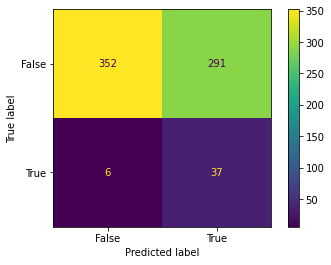

In [ ]:
# Build confusion matrix with training prediction results
conf_matrix = metrics.confusion_matrix(train_true_array, train_prediction_array)
df_conf_matrix = pd.DataFrame(conf_matrix/np.sum(conf_matrix) *10, index = [1, 0], columns = [1, 0])

# Display confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
cm_display.plot()

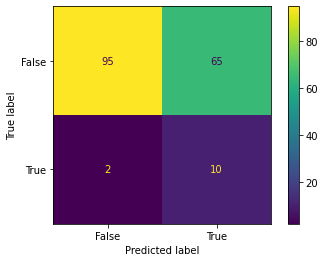

In [ ]:
# Build confusion matrix with test prediction results
conf_matrix = metrics.confusion_matrix(test_true_array, test_prediction_array)
df_conf_matrix = pd.DataFrame(conf_matrix/np.sum(conf_matrix) *10, index = [1, 0], columns = [1, 0])

# Display confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
cm_display.plot()

In [ ]:
# leveraging skater for feature importances
train_dataset[train_dataset == 0] = 0.000000001
test_dataset[test_dataset == 0] = 0.000000001

# create Interpretation model and InMemoryModel with skater library
interpreter = Interpretation(test_dataset, feature_names=sd_column_headers)
im_model = InMemoryModel(trainer.predict_prob, examples=train_dataset)

# plot the feature importance plots:
# If the model can return each feature's importance, contribution to the model's result, 
# the resutl shows the feature importance chart 
plots = interpreter.feature_importance.plot_feature_importance(im_model, ascending = False)

2022-12-01 05:17:14,933 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[14/14] features ████████████████████ Time elapsed: 1 seconds

FeatureImportanceError: ignored